In [5]:
import sys
from pathlib import Path

# Add project root to sys.path
project_root = Path().resolve().parent
sys.path.append(str(project_root))

Load Data

In [6]:
from src.preprocessing import preprocess_data
from src.segmentation import segment_customers
from src.config import RAW_DATA_PATH

df = preprocess_data(RAW_DATA_PATH)
df, kmeans, scaler = segment_customers(df, n_clusters=4)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,service_count,segment
0,7590-VHVEG,Female,No,Yes,No,1,0,0,1,0,...,0,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-12 Months,2,3
1,5575-GNVDE,Male,No,No,No,34,1,0,1,1,...,0,One year,No,Mailed check,56.95,1889.50,No,12-36 Months,4,2
2,3668-QPYBK,Male,No,No,No,2,1,0,1,1,...,0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-12 Months,4,2
3,7795-CFOCW,Male,No,No,No,45,0,0,1,1,...,0,One year,No,Bank transfer (automatic),42.30,1840.75,No,36-60 Months,4,0
4,9237-HQITU,Female,No,No,No,2,1,0,1,0,...,0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-12 Months,2,3


Define CLV : 

CLV = MonthlyCharges × tenure

In [7]:
# Define CLV
df["CLV"] = df["MonthlyCharges"] * df["tenure"]

Segment-Level CLV Summary

In [8]:
segment_clv = df.groupby("segment").agg(
    total_customers=("segment", "count"),
    churned_customers=("Churn", lambda x: (x == "Yes").sum()),
    avg_monthly_revenue=("MonthlyCharges", "mean"),
    avg_clv=("CLV", "mean")
)

segment_clv["revenue_at_risk"] = (
    segment_clv["churned_customers"] *
    segment_clv["avg_clv"]
)

segment_clv

,total_customers,churned_customers,avg_monthly_revenue,avg_clv,revenue_at_risk
segment,,,,,
0,992,44,30.101210,1615.046724,7.106206e+04
1,1995,299,92.030125,5446.673559,1.628555e+06
2,2331,1028,78.877349,1338.683870,1.376167e+06
3,1725,498,34.082899,270.364783,1.346417e+05


Visualize Revenue at Risk

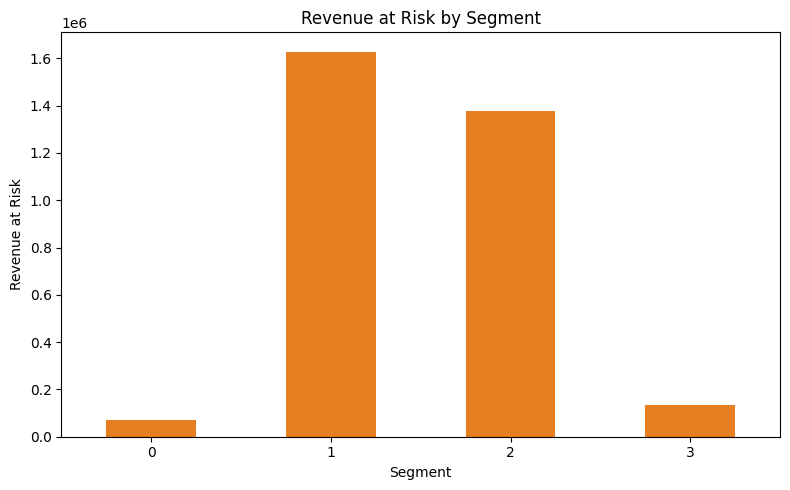

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

segment_clv["revenue_at_risk"].plot(
    kind="bar",
    color="#E67E22",
    ax=ax
)

ax.set_xlabel("Segment")
ax.set_ylabel("Revenue at Risk")
ax.set_title("Revenue at Risk by Segment")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

<b>CLV & Revenue Risk Insights</b>

<ul><li>
<b>Segment 1</b> contributes the highest revenue at risk <b>(~1.63M)</b> due to high customer value, despite relatively moderate churn.
</li><li>
<b>Segment 2</b>contributes <b>~1.38M</b> in revenue at risk, driven by a very high churn volume.
</li><li>
<b>Segment 3</b> exhibits moderate churn but low average CLV, resulting in limited revenue exposure.
</li><li>
<b>Segment 0</b> is highly stable and contributes minimal revenue risk.
</li></ul>
<br>
Revenue risk is primarily concentrated in high-value and high-volume segments, indicating that retention strategy should focus on <b>Segment 1 (value protection) and Segment 2 (churn reduction)</b>.